In [77]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import lmpsetup
import hmdsetup

import lmp
import hmd

import matplotlib.gridspec as gridspec
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import analysis

import scipy.constants as cnt

import shutil
import os
import mdtraj as md
import statsmodels.tsa.stattools
import MDAnalysis.analysis as mda
import scipy
from matplotlib.lines import Line2D


from style_vars import *
plt.style.use('default')
plt.style.use('style.mplstyle')

hps_lines = [Line2D([0], [0], color='black', ls='--'),
                Line2D([0], [0], color='black')]

wt_d4_lines = [Line2D([0], [0], color=C_W),
                Line2D([0], [0], color=C_4)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
wt_cs, wt_ds = [], []
d4_cs, d4_ds = [], []
d7_cs, d7_ds = [], []
d12_cs, d12_ds =[], []
for T in range(8):
    wt_ds.append(np.genfromtxt(f'/home/adria/contacts/dij_WT_{T}.txt'))
    d4_ds.append(np.genfromtxt(f'/home/adria/contacts/dij_D4_{T}.txt'))
    d7_ds.append(np.genfromtxt(f'/home/adria/contacts/dij_7D_WT_{T}.txt'))
    d12_ds.append(np.genfromtxt(f'/home/adria/contacts/dij_12D_D4_{T}.txt'))
    
    wt_cs.append(np.genfromtxt(f'/home/adria/contacts/c_WT_{T}.txt'))
    d4_cs.append(np.genfromtxt(f'/home/adria/contacts/c_D4_{T}.txt'))
    d7_cs.append(np.genfromtxt(f'/home/adria/contacts/c_7D_WT_{T}.txt'))
    d12_cs.append(np.genfromtxt(f'/home/adria/contacts/c_12D_D4_{T}.txt'))
wt_ds, wt_cs = np.array(wt_ds), np.array(wt_cs)
d4_ds, d4_cs = np.array(d4_ds), np.array(d4_cs) 
d7_ds, d7_cs = np.array(d7_ds), np.array(d7_cs)
d12_ds, d12_cs = np.array(d12_ds), np.array(d12_cs)

In [13]:
wt_h = lmp.LMP(md_dir='/home/adria/data/real_final/HPS-T/0.8/WT')

> Run Completed at 100.00% for CPEB4_alpha. Ran 1000000000 steps for a total of 100001 frames 
> Taking frames every 10 for a total of [10001, 10001, 10001, 10001, 10001, 10001, 10001, 10001] to avoid strong correlations


In [112]:
def plot_cmaps(cmap1, temps_idx, vmin, vmax, cmap2=None, cmap=newcmp):
    temps = np.linspace(280,400,8)

    fig = plt.figure(figsize=(16, 16))

    # grid = plt.GridSpec(7, 7, wspace=0., hspace=0.2)
    grid = plt.GridSpec(7, 7, wspace=0.1, hspace=0.1)


    for i, t in enumerate(temps_idx):
        ax = plt.subplot(grid[:2, (t+1):(t+3)])
        if cmap2 is None:
            img = ax.imshow(cmap1[t,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            img = ax.imshow(cmap1[t,:,:]-cmap2[t,:,:], cmap=cmap, vmin=vmin, vmax=vmax)
    #     img = ax.imshow(wtds[t,:,:], cmap='PRGn', vmax=0.05)
        ax.set_title(f"{temps[t]:.0f} K")
        ax.invert_yaxis()
        ax.set_xticks([])
        ax.set_yticks([])

    win, plus, minus = wt_h.get_charge_seq()

    with open('/home/adria/scripts/data/sequences/CPEB4.seq') as wt:
        wt_seq = wt.readlines()[0]
    with open('/home/adria/scripts/data/sequences/CPEB4_D4.seq') as d4:
        d4_seq = d4.readlines()[0]
    with open('/home/adria/scripts/data/sequences/12D_CPEB4_D4.seq') as d12:
        d12_seq = d12.readlines()[0]
    with open('/home/adria/scripts/data/sequences/7D_CPEB4.seq') as d7:
        d7_seq = d7.readlines()[0]

    for i, j in enumerate(temps_idx):
        ax = plt.subplot(grid[2:3, (j+1):(j+3)])
        for i,p in enumerate(plus):
            if p!=0.:
                ax.axvline(i,0.5,p+0.5, color='blue')
        for i,p in enumerate(minus):
            if p!=0.:
                ax.axvline(i,0.5,p+0.5, color='red')
        ax.axvspan(403,411, alpha=0.2, color='orange')
        ax.axhline(0, color='black', lw=2)
        ax.set_ylim(-0.6, 0.6)
        ax.set_xlim(-5,450)
        ax.set_xlim(0,448)
    #     ax.set_xlabel("")
    #     ax.set_xlabel("Residue", fontsize=16)
        ax.set_yticks([])
        ax.set_xticks([50,150,250,350])
        ax.tick_params(axis='both', which='major', labelsize=16)

    ax = plt.subplot(grid[:2, :1])
    for i,p in enumerate(plus):
        if p!=0.:
            ax.axhline(i,0.5,p+0.5, color='blue')
    for i,p in enumerate(minus):
        if p!=0.:
            ax.axhline(i,0.5,p+0.5, color='red')
    ax.axhspan(403,411, alpha=0.2, color='orange')
    ax.axvline(0.5, color='black', lw=2)
    # ax.set_ylabel("Residue", fontsize=16)
    ax.set_yticks([50,150,250,350])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([])

    plt.subplot(grid[2:3, 1:3]).set_ylabel("$\langle q⟩_9$", fontsize=18)
    plt.subplot(grid[:2, :1]).set_xlabel("$\langle q⟩_9$", fontsize=18)
    fig.tight_layout()

    cbar_ax = fig.add_axes([0.4, 0.50, 0.28, 0.02])
    cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
    cbar.ax.invert_xaxis()
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('$d_{ij, WT}-d_{ij, D4}$', rotation=0, fontsize=16, labelpad=0)

/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


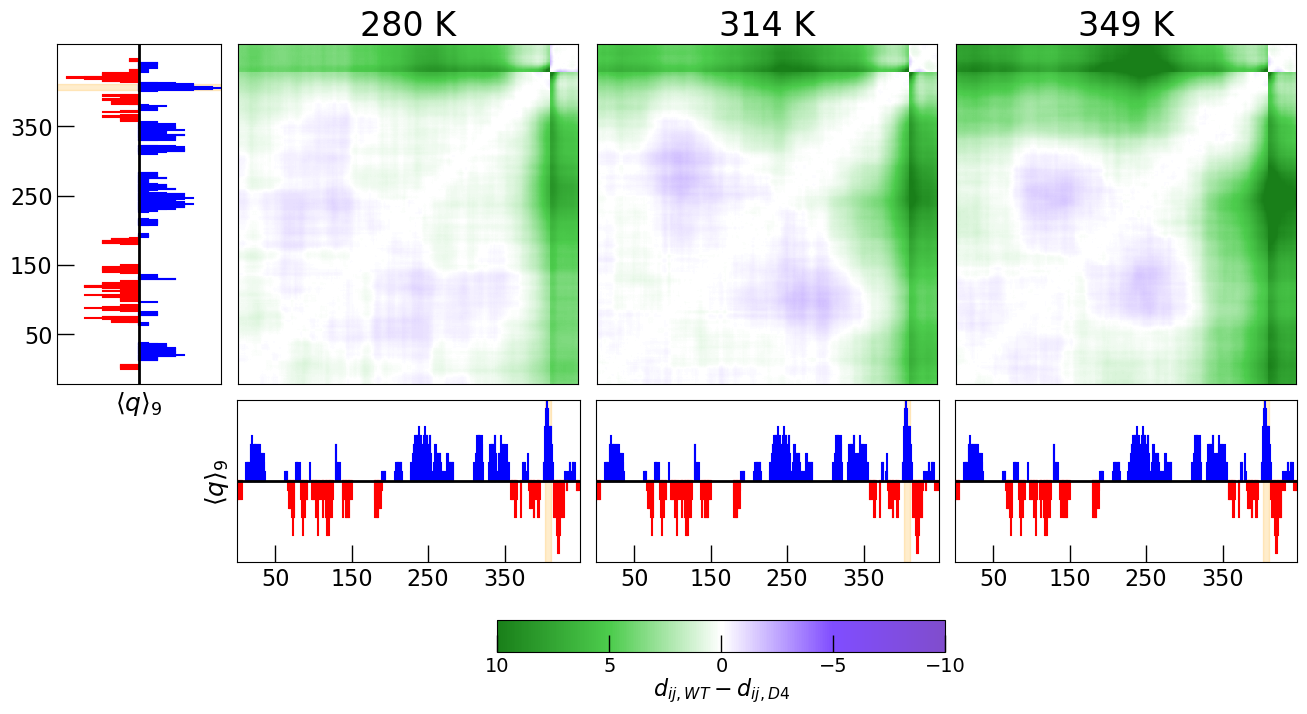

In [113]:
s = wt_ds.copy()
s = np.delete(s, np.arange(402, 410), axis=2)
s = np.delete(s, np.arange(402, 410), axis=1)
plot_cmaps(cmap1=s, cmap2=d4_ds, temps_idx=[0,2,4], vmin=-10, vmax=10, cmap=newcmp)

/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


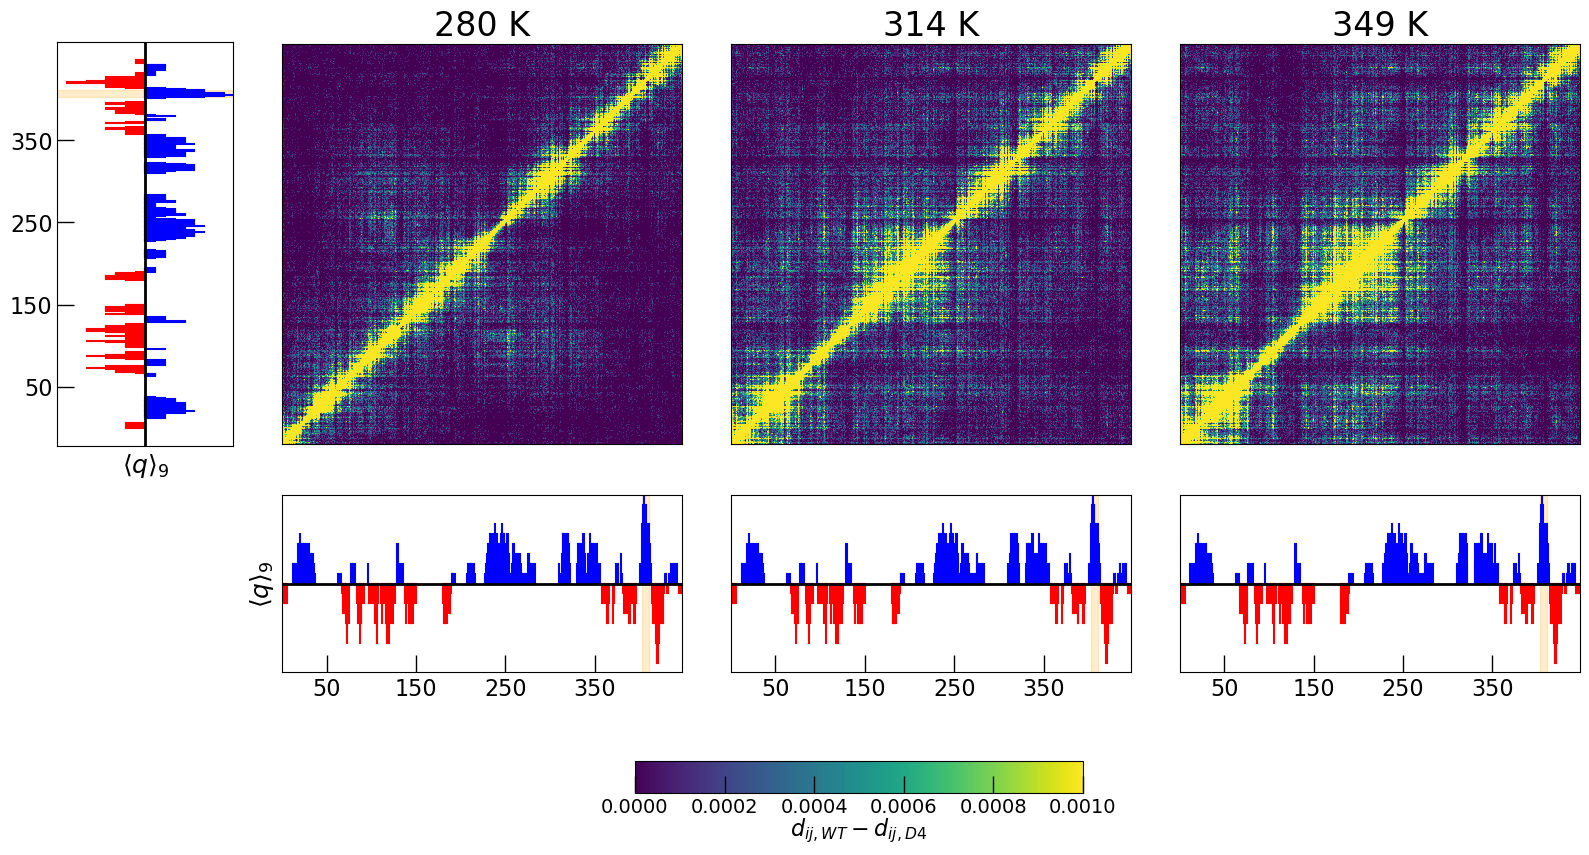

In [100]:
plot_cmaps(cmap1=wt_cs, temps_idx=[0,2,4], vmin=0, vmax=0.001, cmap='viridis')

/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


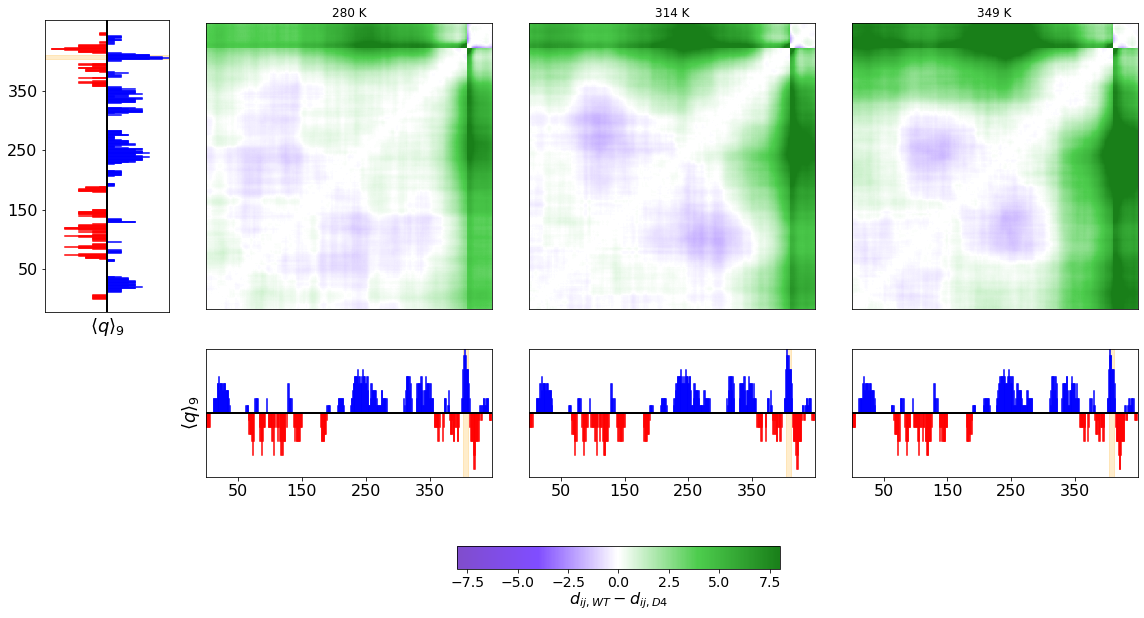

In [74]:
temps = np.linspace(280,400,8)

fig = plt.figure(figsize=(16, 16))

# grid = plt.GridSpec(7, 7, wspace=0., hspace=0.2)
grid = plt.GridSpec(7, 7)


for i, t in enumerate([0,2,4]):
    ax = plt.subplot(grid[:2, (t+1):(t+3)])
    s = wt_ds.copy()
    s = np.delete(s, np.arange(402, 410), axis=2)
    s = np.delete(s, np.arange(402, 410), axis=1)
    img = ax.imshow(s[t,:,:]-d4_ds[t,:,:], cmap=newcmp, vmin=-8, vmax=8)
#     img = ax.imshow(wtds[t,:,:], cmap='PRGn', vmax=0.05)
    ax.set_title(f"{temps[t]:.0f} K")
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])

win, plus, minus = wt_h.get_charge_seq()

with open('/home/adria/scripts/data/sequences/CPEB4.seq') as wt:
    wt_seq = wt.readlines()[0]
with open('/home/adria/scripts/data/sequences/CPEB4_D4.seq') as d4:
    d4_seq = d4.readlines()[0]
with open('/home/adria/scripts/data/sequences/12D_CPEB4_D4.seq') as d12:
    d12_seq = d12.readlines()[0]
with open('/home/adria/scripts/data/sequences/7D_CPEB4.seq') as d7:
    d7_seq = d7.readlines()[0]
    
for i, j in enumerate([0,2,4]):
    ax = plt.subplot(grid[2:3, (j+1):(j+3)])
    for i,p in enumerate(plus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='blue')
    for i,p in enumerate(minus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='red')
    ax.axvspan(403,411, alpha=0.2, color='orange')
    ax.axhline(0, color='black', lw=2)
    ax.set_ylim(-0.6, 0.6)
    ax.set_xlim(-5,450)
    ax.set_xlim(0,448)
#     ax.set_xlabel("")
#     ax.set_xlabel("Residue", fontsize=16)
    ax.set_yticks([])
    ax.set_xticks([50,150,250,350])
    ax.tick_params(axis='both', which='major', labelsize=16)
    
ax = plt.subplot(grid[:2, :1])
for i,p in enumerate(plus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='blue')
for i,p in enumerate(minus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='red')
ax.axhspan(403,411, alpha=0.2, color='orange')
ax.axvline(0.5, color='black', lw=2)
# ax.set_ylabel("Residue", fontsize=16)
ax.set_yticks([50,150,250,350])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([])
    
plt.subplot(grid[2:3, 1:3]).set_ylabel("$\langle q⟩_9$", fontsize=18)
plt.subplot(grid[:2, :1]).set_xlabel("$\langle q⟩_9$", fontsize=18)
fig.tight_layout()

cbar_ax = fig.add_axes([0.4, 0.50, 0.28, 0.02])
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$d_{ij, WT}-d_{ij, D4}$', rotation=0, fontsize=16, labelpad=0)

In [47]:
viridis = plt.get_cmap('viridis', 256)
ds = viridis(np.linspace(0, 1, 256))

ds[:]=0
ds[:,3] = 1
ds[:64,0]=np.linspace(0.3,1,64)
ds[:64,1]=np.linspace(0.0,0.3,64)
ds[:64,2]=np.linspace(0,0,64)

ds[64:128,0]=np.linspace(1,1,64)
ds[64:128,1]=np.linspace(0.3,1,64)
ds[64:128,2]=np.linspace(0,1,64)

ds[128:192,0]=np.linspace(1,0.5,64)
ds[128:192,1]=np.linspace(1,0.3,64)
ds[128:192,2]=np.linspace(1,1,64)

ds[192:256,0]=np.linspace(0.5,0.5,64)
ds[192:256,1]=np.linspace(0.3,0.3,64)
ds[192:256,2]=np.linspace(1,0.8,64)

# ds[128:192,0]=1
# ds[192:256,2]=np.linspace(1,0.3,64)
# ds[128:192,0]=np.linspace(1,0,64)
# ds[128:192,1]=np.linspace(1,0,64)

ds = np.flip(ds,axis=0)
newcmp = ListedColormap(ds)


**BY POS**

/home/adria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


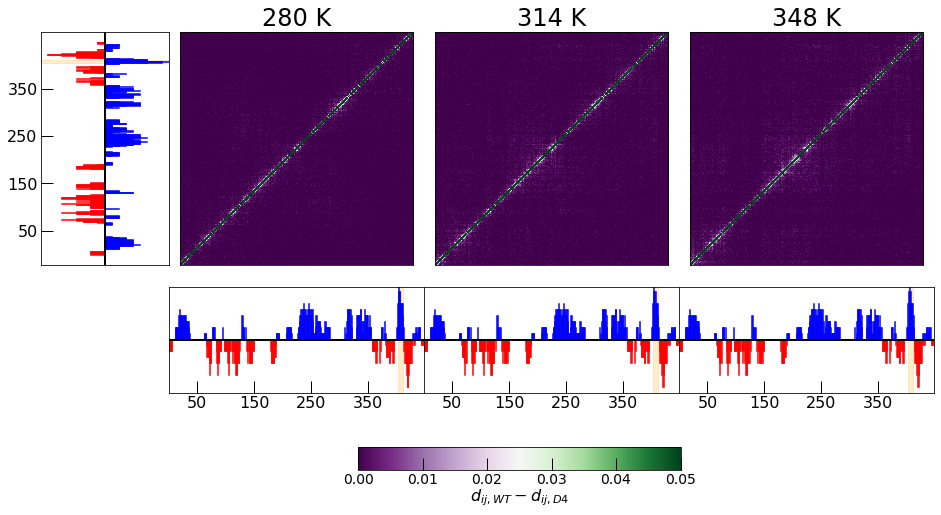

In [65]:
# from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

fig = plt.figure(figsize=(16, 16))

grid = plt.GridSpec(7, 7, wspace=0., hspace=0.2)
viridis = plt.get_cmap('viridis', 256)
ds = viridis(np.linspace(0, 1, 256))

ds[:]=0
ds[:,3] = 1
ds[:64,1]=np.linspace(0.3,1,64)
ds[:64,0]=np.linspace(0,0.5,64)
ds[:64,2]=np.linspace(0,0.5,64)
ds[64:128,1]=1
ds[64:128,0]=np.linspace(0.5,1,64)
ds[64:128,2]=np.linspace(0.5,1,64)

ds[128:192,0]=1
ds[128:192,1]=np.linspace(1,0,64)
ds[128:192,2]=np.linspace(1,0,64)
ds[192:256,0]=np.linspace(1,0.3,64)

ds = np.flip(ds,axis=0)
newcmp = ListedColormap(ds)

for i, t in enumerate([0,2,4]):
    ax = plt.subplot(grid[:2, (t+1):(t+3)])
    s = wt_cmaps.copy()
    s = np.delete(s, np.arange(402, 410), axis=2)
    s = np.delete(s, np.arange(402, 410), axis=1)
#     img = ax.imshow(s[t,:,:]-d4_cmaps[t,:,:], vmin=-10, cmap='PRGn', vmax=10)
    img = ax.imshow(d4_cmaps[t,:,:], cmap='PRGn', vmax=0.05)
    ax.set_title(f"{wt_1.temperatures[t]:.0f} K")
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])

win, plus, minus = wt_1.get_charge_seq()

with open('/home/adria/scripts/data/sequences/CPEB4.seq') as wt:
    wt_seq = wt.readlines()[0]
with open('/home/adria/scripts/data/sequences/CPEB4_D4.seq') as d4:
    d4_seq = d4.readlines()[0]
with open('/home/adria/scripts/data/sequences/12D_CPEB4_D4.seq') as d12:
    d12_seq = d12.readlines()[0]
with open('/home/adria/scripts/data/sequences/7D_CPEB4.seq') as d7:
    d7_seq = d7.readlines()[0]
    
for i, j in enumerate([0,2,4]):
    ax = plt.subplot(grid[2:3, (j+1):(j+3)])
    for i,p in enumerate(plus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='blue')
    for i,p in enumerate(minus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='red')
    ax.axvspan(403,411, alpha=0.2, color='orange')
    ax.axhline(0, color='black', lw=2)
    ax.set_ylim(-0.6, 0.6)
    ax.set_xlim(-5,450)
    ax.set_xlim(0,448)
#     ax.set_xlabel("")
#     ax.set_xlabel("Residue", fontsize=16)
    ax.set_yticks([])
    ax.set_xticks([50,150,250,350])
    ax.tick_params(axis='both', which='major', labelsize=16)
    
ax = plt.subplot(grid[:2, :1])
for i,p in enumerate(plus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='blue')
for i,p in enumerate(minus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='red')
ax.axhspan(403,411, alpha=0.2, color='orange')
ax.axvline(0.5, color='black', lw=2)
# ax.set_ylabel("Residue", fontsize=16)
ax.set_yticks([50,150,250,350])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([])
    
# plt.subplot(grid[2:3, 1:3]).set_ylabel("$\langle q⟩_9$")
# plt.subplot(grid[:2, :1]).set_xlabel("$\langle q⟩_9$")
fig.tight_layout()

cbar_ax = fig.add_axes([0.4, 0.50, 0.28, 0.02])
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$d_{ij, WT}-d_{ij, D4}$', rotation=0, fontsize=16, labelpad=0)

**BY TYPE**

{0: 34, 1: 18, 2: 30, 3: 17, 4: 1, 5: 32, 6: 19, 7: 43, 8: 27, 9: 17, 10: 28, 11: 14, 12: 5, 13: 24, 14: 45, 15: 58, 16: 18, 17: 6, 18: 6, 19: 6}
{0: 34, 1: 18, 2: 30, 3: 17, 4: 1, 5: 32, 6: 19, 7: 43, 8: 27, 9: 17, 10: 28, 11: 14, 12: 5, 13: 24, 14: 45, 15: 58, 16: 18, 17: 6, 18: 6, 19: 6}
{0: 34, 1: 18, 2: 30, 3: 17, 4: 1, 5: 32, 6: 19, 7: 43, 8: 27, 9: 17, 10: 28, 11: 14, 12: 5, 13: 24, 14: 45, 15: 58, 16: 18, 17: 6, 18: 6, 19: 6}
{0: 34, 1: 18, 2: 30, 3: 17, 4: 1, 5: 32, 6: 19, 7: 43, 8: 27, 9: 17, 10: 28, 11: 14, 12: 5, 13: 24, 14: 45, 15: 58, 16: 18, 17: 6, 18: 6, 19: 6}


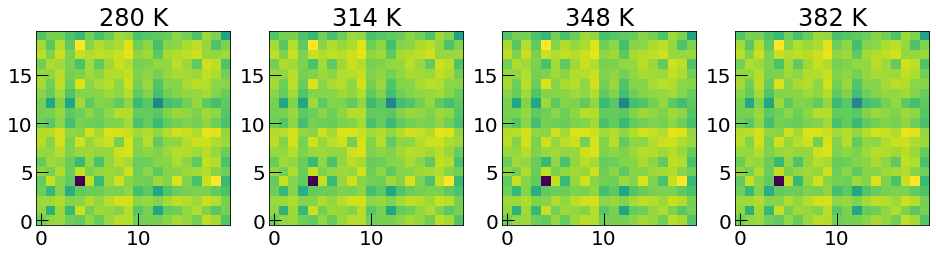

In [7]:
fig, ax = plt.subplots(1,4,figsize=(16,16))
for i, t in enumerate([0,2,4,6]):
#     ax = plt.subplot(grid[:2, (i*2+1):((i+1)*2+1)])
    aa_map = wt_1.map_to_residue(contacts=wt_cmaps[t,:,:], normed=True)
    img = ax[i].imshow(aa_map)
    ax[i].set_title(f"{wt_1.temperatures[t]:.0f} K")
    ax[i].invert_yaxis()
#     ax.set_xticks([])
#     ax.set_yticks([])

In [ ]:
# from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


fig = plt.figure(figsize=(16, 16))

grid = plt.GridSpec(9, 9, wspace=0., hspace=0.)
viridis = cm.get_cmap('viridis', 256)
ds = viridis(np.linspace(0, 1, 256))

ds[:]=0
ds[:,3] = 1
ds[:64,1]=np.linspace(0.3,1,64)
ds[:64,0]=np.linspace(0,0.5,64)
ds[:64,2]=np.linspace(0,0.5,64)
ds[64:128,1]=1
ds[64:128,0]=np.linspace(0.5,1,64)
ds[64:128,2]=np.linspace(0.5,1,64)

ds[128:192,0]=1
ds[128:192,1]=np.linspace(1,0,64)
ds[128:192,2]=np.linspace(1,0,64)
ds[192:256,0]=np.linspace(1,0.3,64)

ds = np.flip(ds,axis=0)
newcmp = ListedColormap(ds)


for i, t in enumerate([0,2,4,6]):
    ax = plt.subplot(grid[:2, (i*2+1):((i+1)*2+1)])
    s = wt_cmaps
    s = np.delete(s, np.arange(402, 410), axis=2)
    s = np.delete(s, np.arange(402, 410), axis=1)
    img = ax.imshow(s[t,:,:]-d4_cmaps[t,:,:], vmin=-15, cmap=newcmp, vmax=15)
    ax.set_title(f"{wt_1.temperatures[t]:.0f} K")
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])

win, plus, minus = wt_1.get_charge_seq()

with open('/home/adria/scripts/data/sequences/CPEB4.seq') as wt:
    wt_seq = wt.readlines()[0]
with open('/home/adria/scripts/data/sequences/CPEB4_D4.seq') as d4:
    d4_seq = d4.readlines()[0]
with open('/home/adria/scripts/data/sequences/12D_CPEB4_D4.seq') as d12:
    d12_seq = d12.readlines()[0]
with open('/home/adria/scripts/data/sequences/7D_CPEB4.seq') as d7:
    d7_seq = d7.readlines()[0]
    
for i, j in enumerate([0,2,4,6]):
    ax = plt.subplot(grid[2:3, (i*2+1):((i+1)*2+1)])
    for i,p in enumerate(plus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='blue')
    for i,p in enumerate(minus):
        if p!=0.:
            ax.axvline(i,0.5,p+0.5, color='red')
    ax.axvspan(403,411, alpha=0.2, color='orange')
    ax.axhline(0, color='black', lw=2)
    ax.set_ylim(-0.6, 0.6)
    ax.set_xlim(-5,450)
    ax.set_xlim(0,448)
#     ax.set_xlabel("")
#     ax.set_xlabel("Residue", fontsize=16)
    ax.set_yticks([])
    ax.set_xticks([50,150,250,350])
    ax.tick_params(axis='both', which='major', labelsize=16)
    
ax = plt.subplot(grid[:2, :1])
for i,p in enumerate(plus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='blue')
for i,p in enumerate(minus):
    if p!=0.:
        ax.axhline(i,0.5,p+0.5, color='red')
ax.axhspan(403,411, alpha=0.2, color='orange')
ax.axvline(0.5, color='black', lw=2)
# ax.set_ylabel("Residue", fontsize=16)
ax.set_yticks([50,150,250,350])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks([])
    
plt.subplot(grid[2:3, 1:3]).set_ylabel("$\langle q⟩_9$")
plt.subplot(grid[:2, :1]).set_xlabel("$\langle q⟩_9$")
# plt.tight_layout()

# fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.4, 0.58, 0.28, 0.02])
cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('$d_{ij, WT}-d_{ij, D4}$', rotation=0, fontsize=16, labelpad=0)

In [ ]:
s = hmd.HMD(md_dir='/home/adria/perdiux/prod/lammps/final/HPS-T/SLABS/0.8-csuc/WT', every=100, total=100)
inter_cmap, intra_cmap = s.inter_distance_map(contacts=True, temperature=1)
img = plt.imshow(inter_cmap[0])
plt.colorbar(img)